# FOOD CLASSIFICATION PROJECT

*Pytorch project for AI Engineering Master with ProfessionAI*

## Colab Configuration

If you're testing this project on Google Colab, it could be useful for you to run the following cells

In [ ]:
# If you are running this code on Google Colab, run this:

!git clone https://github.com/Silvano315/PyTorch-CNN-for-food-image-classification-system.git

%cd PyTorch-CNN-for-food-image-classification-system
%pwd

In [ ]:
# Extract dataset from Google Drive (dataset folder or zip file)

from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/Project_PyTorch_ProfessionAI/dataset/ /content/PyTorch-CNN-for-food-image-classification-system/

#from src.utils import extract_dataset
#extract_dataset("/content/drive/MyDrive/Project_PyTorch_ProfessionAI/dataset_food_classification.zip", 
#                '')

In [9]:
# Extract dataset from url or from a local folder

from src.utils import extract_dataset

extract_dataset("https://proai-datasets.s3.eu-west-3.amazonaws.com/dataset_food_classification.zip", 
                '')

Downloading: 100%|██████████| 1.07G/1.07G [02:56<00:00, 6.09MiB/s]
Extracting files: 100%|██████████| 14047/14047 [00:06<00:00, 2246.00file/s]


Dataset extracted to .
Total files extracted: 14047
Removing macOS hidden files...
Removed 7 macOS hidden files/folders
Final number of files: 14040


## Import Libraries and initial Set-Up

In [1]:
# Import libraries

import os
import sys
import json
import random
import logging
import time

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import albumentations as A
from albumentations.pytorch import ToTensorV2

from src.constants import RANDOM_SEED, DATA_PATH, BATCH_SIZE
from src.utils import get_paths_to_files, get_dataset_paths, get_logger
from src.viz_fx import display_random_images, visualize_class_samples, plot_class_distribution, compare_class_distribution, \
                        analyze_image_dimensions, analyze_color_distribution, visualize_random_images, visualize_augmented_images, \
                        scatter_plot_metrics, plot_confusion_matrix, visualize_random_gradcam
from src.preprocessing import create_datasets, create_data_loaders
from src.models import create_model, Experiment, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, train_model, validate, \
                        get_predictions, freeze_layers

/Users/silvanoquarto/Desktop/PROJECTS/Master_AI_Engineering/PyTorch-DNN-for-food-image-classification-system/.venv/lib/python3.11/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Set Random Seed for reproducibility

os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [3]:
# Check if GPU is available and set it as device 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"This repository is connected to {str(device).upper()}")

This repository is connected to CPU


## Exploratory Data Analysis

In [4]:
# Get paths and filenames form directory dataset 

filepaths, filenames = get_paths_to_files(DATA_PATH)

print("="*80)
print("File paths:")
for i in range(0,5):
    print(filepaths[i])
print("="*80)
print("File names:")
for i in range(0,5):
    print(filenames[i])
print("="*80)

File paths:
dataset/test/Sandwich/Sandwich-Train (36)_e50a3a403c2741408f47d8bda7e28d1f.jpeg
dataset/test/Sandwich/Sandwich-Train (465)_f1e4e45cc2c846f19b6e2faefe8f4600.jpeg
dataset/test/Sandwich/Sandwich-Train (1162)_8f665882c03c496eba53724221b04846.jpeg
dataset/test/Sandwich/Sandwich-Train (578)_3b7f8599e1b4472f9db6fa7666eae82c.jpeg
dataset/test/Sandwich/Sandwich-Train (717)_4603bb6b236e48e9974d6b07dce7157c.jpeg
File names:
Sandwich-Train (36)_e50a3a403c2741408f47d8bda7e28d1f.jpeg
Sandwich-Train (465)_f1e4e45cc2c846f19b6e2faefe8f4600.jpeg
Sandwich-Train (1162)_8f665882c03c496eba53724221b04846.jpeg
Sandwich-Train (578)_3b7f8599e1b4472f9db6fa7666eae82c.jpeg
Sandwich-Train (717)_4603bb6b236e48e9974d6b07dce7157c.jpeg


In [5]:
# Access to path dirs and file names for each split (test, train, val)

dataset_paths = get_dataset_paths(DATA_PATH)

train_paths, train_names = dataset_paths['train']
test_paths, test_names = dataset_paths['test']
val_paths, val_names = dataset_paths['val']

print("="*80)
print("File paths:")
for i in range(0,5):
    print(train_paths[i])
print("="*80)
print("File names:")
for i in range(0,5):
    print(train_names[i])
print("="*80)

File paths:
dataset/train/Sandwich/Sandwich-Train (277)_436fb6c2c1fc4e91a9be68c03e8e45a4.jpeg
dataset/train/Sandwich/Sandwich-Train (161)_02ffbe626d9c4d969a256034e0617fdc.jpeg
dataset/train/Sandwich/Sandwich-Train (1368)_627dc1a3443d4750bafe0ca7d446ed0b.jpeg
dataset/train/Sandwich/Sandwich-Train (1016)_b9a1f780c2b54c4a8af769240dfbddb9.jpeg
dataset/train/Sandwich/Sandwich-Train (318)_778f0227997d4e50b16153d8516e5088.jpeg
File names:
Sandwich-Train (277)_436fb6c2c1fc4e91a9be68c03e8e45a4.jpeg
Sandwich-Train (161)_02ffbe626d9c4d969a256034e0617fdc.jpeg
Sandwich-Train (1368)_627dc1a3443d4750bafe0ca7d446ed0b.jpeg
Sandwich-Train (1016)_b9a1f780c2b54c4a8af769240dfbddb9.jpeg
Sandwich-Train (318)_778f0227997d4e50b16153d8516e5088.jpeg


In [ ]:
# Visualize n random images 

fig, axes = display_random_images(filepaths, n=25)
plt.show() 

In [ ]:
# Visualize n random images from a chosen split dataset (train_paths, test_paths, val_paths)

chosen_split = train_paths

fig, axes = display_random_images(chosen_split, n=25)
plt.show() 

In [ ]:
# Displays sample images for each class in the chosen split set

chosen_split = train_paths

fig = visualize_class_samples(chosen_split, num_samples=3, max_classes=11)
plt.show()

In [6]:
# Bar plot for class distribution for each dataset split

chosen_split = val_paths

class_dist_fig = plot_class_distribution(chosen_split)
class_dist_fig.show()

In [6]:
# Comparison of the Class Distribution between Train, Test e Validation

comparison_fig = compare_class_distribution(dataset_paths)
comparison_fig.show()

In [9]:
# Several plots to analyze Images Dimensions

dim_fig = analyze_image_dimensions(test_paths)
dim_fig.show()


In [ ]:
# Histogram Plots to analyze Colour Distribution for a chosen split dataset

chosen_split = train_paths

color_dist_fig = analyze_color_distribution(chosen_split, n_samples=50)
color_dist_fig.show()

## Preprocessing with image visualization

In [4]:
# Preprocessing for Baseline Model (without augmentation, also for train set)
# Resize Dimensions (224,224) and Normalization

trainset, valset, testset = create_datasets(DATA_PATH, augment_train=False)

print('='*60 + "\nTrain:")
print(trainset)
print('='*60 + "\Val:")
print(valset)
print('='*60 + "\Test:")
print(testset)
print("="*60)

Train:
Dataset ImageFolder
    Number of datapoints: 8960
    Root location: dataset//train
    StandardTransform
Transform: <src.preprocessing.Transforms object at 0x2a06bd0d0>
============================================================\Val:
Dataset ImageFolder
    Number of datapoints: 2240
    Root location: dataset//val
    StandardTransform
Transform: <src.preprocessing.Transforms object at 0x2a0b10cd0>
============================================================\Test:
Dataset ImageFolder
    Number of datapoints: 2800
    Root location: dataset//test
    StandardTransform
Transform: <src.preprocessing.Transforms object at 0x2a0b10cd0>


In [ ]:
# Visualization of random images from ImageFolder

chosen_folder = trainset

visualize_random_images(chosen_folder, num_images=16, axis=False)

In [7]:
# Preprocessing for Transfer Learning Model (with augmentation for train set)
# Resize Dimensions (224,224) and Normalization

trainset_aug, valset, testset = create_datasets(DATA_PATH, augment_train=True)

print('='*60 + "\nTrain:")
print(trainset_aug)
print('='*60 + "\Val:")
print(valset)
print('='*60 + "\Test:")
print(testset)
print("="*60)

Train:
Dataset ImageFolder
    Number of datapoints: 8960
    Root location: dataset//train
    StandardTransform
Transform: <src.preprocessing.Transforms object at 0x1082fdc90>
============================================================\Val:
Dataset ImageFolder
    Number of datapoints: 2240
    Root location: dataset//val
    StandardTransform
Transform: <src.preprocessing.Transforms object at 0x2a2655510>
============================================================\Test:
Dataset ImageFolder
    Number of datapoints: 2800
    Root location: dataset//test
    StandardTransform
Transform: <src.preprocessing.Transforms object at 0x2a2655510>


/Users/silvanoquarto/Desktop/PROJECTS/Master_AI_Engineering/PyTorch-DNN-for-food-image-classification-system/.venv/lib/python3.11/site-packages/pydantic/main.py:212: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


In [ ]:
# Visualization of random augmented images from ImageFolder

visualize_augmented_images(trainset_aug, num_images=5)

In [5]:
# Create DataLoader for each dataset split

is_augmented = False
datasets = {
    'train': trainset_aug if is_augmented else trainset,
    'val': valset,
    'test': testset
}

dataloaders = create_data_loaders(datasets, batch_size=BATCH_SIZE, num_workers=0)

train_loader = dataloaders['train']
val_loader = dataloaders['val']
test_loader = dataloaders['test']

## Baseline Model without augmentation

### Preprocessing

In [4]:
# Preprocessing for Baseline Model (without augmentation, also for train set)
# Resize Dimensions (224,224) and Normalization

trainset, valset, testset = create_datasets(DATA_PATH, augment_train=False)

print('='*60 + "\nTrain:")
print(trainset)
print('='*60 + "\Val:")
print(valset)
print('='*60 + "\Test:")
print(testset)
print("="*60)

Train:
Dataset ImageFolder
    Number of datapoints: 8960
    Root location: dataset//train
    StandardTransform
Transform: <src.preprocessing.Transforms object at 0x2975541d0>
============================================================\Val:
Dataset ImageFolder
    Number of datapoints: 2240
    Root location: dataset//val
    StandardTransform
Transform: <src.preprocessing.Transforms object at 0x298883c50>
============================================================\Test:
Dataset ImageFolder
    Number of datapoints: 2800
    Root location: dataset//test
    StandardTransform
Transform: <src.preprocessing.Transforms object at 0x298883c50>


In [5]:
# Create DataLoader for each dataset split

is_augmented = False
datasets = {
    'train': trainset_aug if is_augmented else trainset,
    'val': valset,
    'test': testset
}

dataloaders = create_data_loaders(datasets, batch_size=BATCH_SIZE, num_workers=0)

train_loader = dataloaders['train']
val_loader = dataloaders['val']
test_loader = dataloaders['test']

### Baseline model creation and training

In [6]:
# Define configurations

num_epochs = 100
learning_rate = 0.001
num_classes = len(trainset.classes)

In [9]:
# Create model and  set to device

logger = get_logger(ch_log_level=logging.INFO, fh_log_level=logging.DEBUG)

model = create_model(num_classes, 'baseline')
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
         MaxPool2d-2         [-1, 32, 112, 112]               0
            Conv2d-3         [-1, 64, 112, 112]          18,496
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]          73,856
         MaxPool2d-6          [-1, 128, 28, 28]               0
 AdaptiveAvgPool2d-7            [-1, 128, 1, 1]               0
           Flatten-8                  [-1, 128]               0
            Linear-9                  [-1, 512]          66,048
          Dropout-10                  [-1, 512]               0
           Linear-11                   [-1, 14]           7,182
Total params: 166,478
Trainable params: 166,478
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/

In [10]:
# Initialize Experiment

experiment = Experiment("BaselineCNN", "experiments")
experiment.init()

In [11]:
# Training step

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=True),
    ModelCheckpoint(filepath='best_model.pth', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True, monitor='val_loss')
]

since = time.time()
trained_model = train_model(model, optimizer, train_loader, val_loader, experiment, callbacks, num_epochs, device, logger)
# To restart from a checkpoint
#train_model(model, train_loader, optimizer, val_loader, experiment, callbacks, num_epochs, device, logger, resume_from='models/best_model_baseline.pth')
time_elapsed = time.time() - since
logger.info('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

In [ ]:
# Plot history

experiment.plot_history()

In [ ]:
# Save model

torch.save(trained_model.state_dict(), 'final_baseline_model.pth')
logger.info("Final model saved as 'final_model.pth'")

### Model Evaluation

In [ ]:
# Evaluation train and validation results

scatter_plot_metrics('experiments/BaselineCNN/history/train.csv', 'experiments/BaselineCNN/history/val.csv')

In [ ]:
# Evaluation on test set

test_logs = validate(trained_model, test_loader, torch.nn.CrossEntropyLoss(), device)
logger.info(f"Test Results: {test_logs}")

In [ ]:
# Generate and plot confusion matrix

y_true, y_pred = get_predictions(trained_model, test_loader, device)
plot_confusion_matrix(y_true, y_pred, classes=trainset.classes)
logger.info("Confusion matrix saved as 'confusion_matrix.png'")

In [ ]:
# Replace missing values with 0 in column lr from val.csv and test.csv (TO BE REFACTORED)

val = pd.read_csv("experiments/BaselineCNN/history/val.csv")
val['lr'] = val['lr'].fillna(0).to_numpy()
val.to_csv("experiments/BaselineCNN/history/val.csv", index=False)

test = pd.read_csv("experiments/BaselineCNN/history/test.csv")
test['lr'] = test['lr'].fillna(0).to_numpy()
test.to_csv("experiments/BaselineCNN/history/test.csv", index=False)

In [ ]:
# Calculate average metrics for last n epochs

experiment = Experiment("BaselineCNN", "experiments")
experiment.load_history_from_file("val")
experiment.load_history_from_file("train")
experiment.load_history_from_file("test")
experiment.load_history_from_file("lr")

avg_metrics = experiment.calculate_average_metrics('val', last_n_epochs=5)
print("Average validation metrics:", avg_metrics)

In [ ]:
# Export results in JSON

experiment.export_results_to_json("results.json")

In [ ]:
# Find best epoch according to validation accuracy 

best_epoch = experiment.get_best_epoch('val_accuracy', mode='max')
print(f"Best validation accuracy was achieved at epoch {best_epoch}")

In [ ]:
# Plot learning rate

experiment.plot_learning_rate(experiment.history['train']['lr'])

## Baseline model with augmentation

### Preprocessing

In [6]:
# Preprocessing for Transfer Learning Model (with augmentation for train set)
# Resize Dimensions (224,224) and Normalization

trainset_aug, valset, testset = create_datasets(DATA_PATH, augment_train=True)

print('='*60 + "\nTrain:")
print(trainset_aug)
print('='*60 + "\Val:")
print(valset)
print('='*60 + "\Test:")
print(testset)
print("="*60)

Train:
Dataset ImageFolder
    Number of datapoints: 8960
    Root location: dataset//train
    StandardTransform
Transform: <src.preprocessing.Transforms object at 0x29ffc9dd0>
============================================================\Val:
Dataset ImageFolder
    Number of datapoints: 2240
    Root location: dataset//val
    StandardTransform
Transform: <src.preprocessing.Transforms object at 0x2a0d15310>
============================================================\Test:
Dataset ImageFolder
    Number of datapoints: 2800
    Root location: dataset//test
    StandardTransform
Transform: <src.preprocessing.Transforms object at 0x2a0d15310>


In [7]:
# Create DataLoader for each dataset split

is_augmented = True
datasets = {
    'train': trainset_aug if is_augmented else trainset,
    'val': valset,
    'test': testset
}

dataloaders = create_data_loaders(datasets, batch_size=BATCH_SIZE, num_workers=0)

train_loader = dataloaders['train']
val_loader = dataloaders['val']
test_loader = dataloaders['test']

### Baseline model creation and training

In [8]:
# Define configurations

num_epochs = 100
learning_rate = 0.001
num_classes = len(trainset_aug.classes)

In [11]:
# Create model and  set to device

logger = get_logger(ch_log_level=logging.INFO, fh_log_level=logging.DEBUG)

model = create_model(num_classes, 'baseline')
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
summary(model, (3,224,224))

In [ ]:
# Initialize Experiment

experiment = Experiment("BaselineCNN_with_aug", "experiments")
experiment.init()

In [ ]:
# Training step

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=True),
    ModelCheckpoint(filepath='best_baseline_model_with_aug.pth', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True, monitor='val_loss')
]

since = time.time()
trained_model = train_model(model, optimizer, train_loader, val_loader, experiment, callbacks, num_epochs, device, logger)
# To restart from a checkpoint
#trained_model = train_model(model, optimizer, train_loader, val_loader, experiment, callbacks, num_epochs, device, logger, resume_from='models/best_model_baseline.pth')
time_elapsed = time.time() - since
logger.info('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

In [ ]:
# Plot history

experiment.plot_history()

### Model Evaluation

In [7]:
# Evaluation train and validation results

scatter_plot_metrics('experiments/BaselineCNN_with_aug/history/train.csv', 'experiments/BaselineCNN_with_aug/history/val.csv')

In [9]:
# load model and checkpoint

model = create_model(num_classes, 'baseline')
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
 
full_model = torch.load('models/best_baseline_model_with_aug.pth', map_location=torch.device(device))
checkpoint = torch.load('models/best_baseline_model_with_aug.pth', map_location=torch.device(device))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
logs = checkpoint['logs']
best = checkpoint['best']

/var/folders/8d/09j2zdrx7klfl7nffqz630000000gn/T/ipykernel_60172/4149932699.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  full_model = torch.load('models/best_baseline

In [ ]:
# Evaluation on test set

test_logs = validate(trained_model, test_loader, torch.nn.CrossEntropyLoss(), device)
experiment.save_history('test', **test_logs)
logger.info(f"Test Results: {test_logs}")

In [ ]:
# Generate and plot confusion matrix

y_true, y_pred = get_predictions(trained_model, test_loader, device)
plot_confusion_matrix(y_true, y_pred, classes=trainset_aug.classes)
logger.info("Confusion matrix saved as 'confusion_matrix.png'")

In [ ]:
# Replace missing values with 0 in column lr from val.csv and test.csv (TO BE REFACTORED)

val = pd.read_csv("experiments/BaselineCNN_with_aug/history/val.csv")
val['lr'] = val['lr'].fillna(0).to_numpy()
val.to_csv("experiments/BaselineCNN_with_aug/history/val.csv", index=False)

test = pd.read_csv("experiments/BaselineCNN_with_aug/history/test.csv")
test['lr'] = test['lr'].fillna(0).to_numpy()
test.to_csv("experiments/BaselineCNN_with_aug/history/test.csv", index=False)

In [32]:
# Calculate average metrics for last n epochs

experiment = Experiment("BaselineCNN_with_aug", "experiments")
experiment.load_history_from_file("val")
experiment.load_history_from_file("train")
experiment.load_history_from_file("test")
experiment.load_history_from_file("lr")


avg_metrics = experiment.calculate_average_metrics('val', last_n_epochs=5)
print("Average validation metrics:", avg_metrics)

Average validation metrics: {'loss': 1.2246237656048367, 'accuracy': 0.5820535714285715, 'precision': 0.5927589367236115, 'recall': 0.5820535714285715, 'f1': 0.5799081119665128}


In [50]:
# Export results in JSON

experiment.export_results_to_json("experiments/BaselineCNN_with_aug/results/results.json")

In [51]:
# Find best epoch according to validation accuracy 

best_epoch = experiment.get_best_epoch('accuracy', mode='max')
print(f"Best validation accuracy was achieved at epoch {best_epoch}")

Best validation accuracy was achieved at epoch 100


In [ ]:
# Plot learning rate

experiment.plot_learning_rate(experiment.history['train']['lr'])

## Transfer Learning with augmentation

### Preprocessing

In [5]:
# Preprocessing for Transfer Learning Model (with augmentation for train set)
# Resize Dimensions (224,224) and Normalization

trainset_aug, valset, testset = create_datasets(DATA_PATH, augment_train=True)

print('='*60 + "\nTrain:")
print(trainset_aug)
print('='*60 + "\Val:")
print(valset)
print('='*60 + "\Test:")
print(testset)
print("="*60)

Train:
Dataset ImageFolder
    Number of datapoints: 8960
    Root location: dataset//train
    StandardTransform
Transform: <src.preprocessing.Transforms object at 0x29ed3e310>
============================================================\Val:
Dataset ImageFolder
    Number of datapoints: 2240
    Root location: dataset//val
    StandardTransform
Transform: <src.preprocessing.Transforms object at 0x2a04a2d10>
============================================================\Test:
Dataset ImageFolder
    Number of datapoints: 2800
    Root location: dataset//test
    StandardTransform
Transform: <src.preprocessing.Transforms object at 0x2a04a2d10>


In [6]:
# Create DataLoader for each dataset split

is_augmented = True
datasets = {
    'train': trainset_aug if is_augmented else trainset,
    'val': valset,
    'test': testset
}

dataloaders = create_data_loaders(datasets, batch_size=BATCH_SIZE, num_workers=0)

train_loader = dataloaders['train']
val_loader = dataloaders['val']
test_loader = dataloaders['test']

### Transfer Learning model creation and training

In [7]:
# Define configurations

num_epochs = 100
learning_rate = 0.001
num_classes = len(trainset_aug.classes)

In [7]:
# Create model and  set to device

logger = get_logger(ch_log_level=logging.INFO, fh_log_level=logging.DEBUG)

model = create_model(num_classes, model_type='efficientnet', efficientnet_version='b0')
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
# for testing fine-tuning 

freeze_layers(model, num_layers=-1)  

In [ ]:
summary(model, (3,224,224))

In [9]:
# Initialize Experiment

experiment = Experiment("EfficientNetB0_TL", "experiments")
experiment.init()

In [ ]:
# Training step

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=True),
    ModelCheckpoint(filepath='best_model_transfer_learning_effcientnet_b0.pth', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
]

since = time.time()
trained_model = train_model(model, optimizer, train_loader, val_loader, experiment, callbacks, num_epochs, device, logger)
# To restart from a checkpoint
#trained_model = train_model(model, train_loader, val_loader, experiment, callbacks, num_epochs, device, logger, 
#resume_from='models/best_model_baseline.pth')
time_elapsed = time.time() - since
logger.info('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

In [ ]:
# Plot history

experiment.plot_history()

### Model Evaluation

In [7]:
# Evaluation train and validation results

scatter_plot_metrics('experiments/EfficientNetB0_TL/history/train.csv', 'experiments/EfficientNetB0_TL/history/val.csv')

In [13]:
# load model and checkpoint

model = create_model(num_classes, model_type='efficientnet', efficientnet_version='b0')
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
 
full_model = torch.load('models/best_model_transfer_learning_effcientnet_b0.pth', map_location=torch.device(device))
checkpoint = torch.load('models/best_model_transfer_learning_effcientnet_b0.pth', map_location=torch.device(device))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
logs = checkpoint['logs']
best = checkpoint['best']

/var/folders/8d/09j2zdrx7klfl7nffqz630000000gn/T/ipykernel_60172/3837306050.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  full_model = torch.load('models/best_model_tr

In [ ]:
# Evaluation on test set

test_logs = validate(trained_model, test_loader, torch.nn.CrossEntropyLoss(), device)
experiment.save_history('test', **test_logs)
logger.info(f"Test Results: {test_logs}")

In [ ]:
# Generate and plot confusion matrix

y_true, y_pred = get_predictions(trained_model, test_loader, device)
plot_confusion_matrix(y_true, y_pred, classes=trainset_aug.classes)
logger.info("Confusion matrix saved as 'confusion_matrix.png'")

In [20]:
# Replace missing values with 0 in column lr from val.csv and test.csv (TO BE REFACTORED)

val = pd.read_csv("experiments/EfficientNetB0_TL/history/val.csv")
val['lr'] = val['lr'].fillna(0).to_numpy()
val.to_csv("experiments/EfficientNetB0_TL/history/val.csv", index=False)

test = pd.read_csv("experiments/EfficientNetB0_TL/history/test.csv")
test['lr'] = test['lr'].fillna(0).to_numpy()
test.to_csv("experiments/EfficientNetB0_TL/history/test.csv", index=False)

In [14]:
# Calculate average metrics for last n epochs

experiment = Experiment("EfficientNetB0_TL", "experiments")
experiment.load_history_from_file("val")
experiment.load_history_from_file("train")
experiment.load_history_from_file("test")


avg_metrics = experiment.calculate_average_metrics('val', last_n_epochs=5)
print("Average validation metrics:", avg_metrics)

Average validation metrics: {'loss': 0.6147917481831142, 'accuracy': 0.8012499999999999, 'precision': 0.8025571241884867, 'recall': 0.8012499999999999, 'f1': 0.8012408234584759, 'lr': 0.0}


In [15]:
# Export results in JSON

experiment.export_results_to_json("experiments/EfficientNetB0_TL/results/results.json")

In [16]:
# Find best epoch according to validation accuracy 

best_epoch = experiment.get_best_epoch('accuracy', mode='max')
print(f"Best validation accuracy was achieved at epoch {best_epoch}")

Best validation accuracy was achieved at epoch 40


In [18]:
# Plot learning rate

experiment.plot_learning_rate(experiment.history['train']['lr'])

## GRAD-CAM for interpretability

In [4]:
# Preprocessing for train val and test

trainset_aug, valset, testset = create_datasets(DATA_PATH, augment_train=True)

is_augmented = True
datasets = {
    'train': trainset_aug if is_augmented else trainset,
    'val': valset,
    'test': testset
}

dataloaders = create_data_loaders(datasets, batch_size=BATCH_SIZE, num_workers=0)

train_loader = dataloaders['train']
val_loader = dataloaders['val']
test_loader = dataloaders['test']

num_classes = len(trainset_aug.classes)
learning_rate = 0.01

In [5]:
# load model and checkpoint

model = create_model(num_classes, model_type='efficientnet', efficientnet_version='b0')
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
 
full_model = torch.load('models/best_model_transfer_learning_effcientnet_b0.pth', map_location=torch.device(device))
checkpoint = torch.load('models/best_model_transfer_learning_effcientnet_b0.pth', map_location=torch.device(device))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
logs = checkpoint['logs']
best = checkpoint['best']

/var/folders/8d/09j2zdrx7klfl7nffqz630000000gn/T/ipykernel_12324/3837306050.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  full_model = torch.load('models/best_model_tr

In [ ]:
# Print layers from the model to check last layer to visualize

for name, module in model.named_modules():
    print(name)

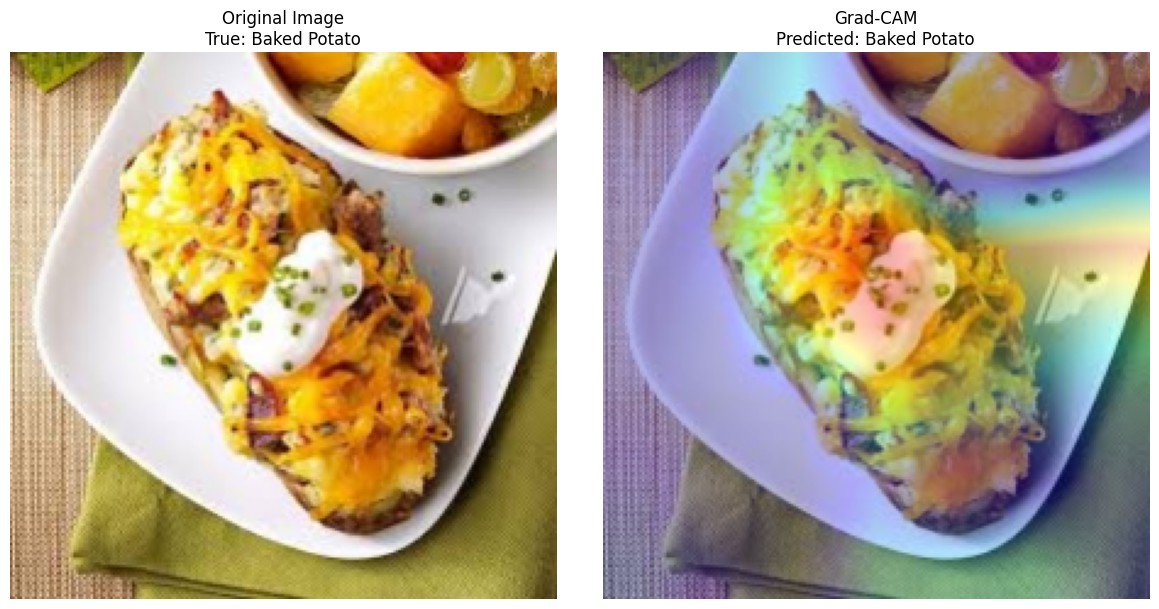

In [6]:
# Visualize original image and its heatmap from GRAD-CAM with corresponding true and predicted label

class_names = testset.classes

visualize_random_gradcam(model, test_loader, class_names, layer_name='last_layer')